# Thinkful Data Science Bootcamp
# Final Capstone

#### Emile Badran - 20/September/2018

## Introduction

In this capstone project, I process tweets from the leading Democratic (Hillary Clinton) and Republican (Donald Trump) candidates and key 2016 US election hashtags. I apply Natural Language Processing and Network Analysis techniques to find the key topics, and the most influential actors that have guided the public debate. The project aims to uncover:

- Which topics/hashtags had the most repercussion (measured in the number of comments and re-tweets) among followers of said candidates?
- What key messages can be extracted from the presidential elections public debate?
- How tightly knit were each presidential candidate’s networks?
- Who were the most influential Twitter users in the debate?

Twitter has become a major source of information and a platform for political dialogue for a considerable number of people in the US and elsewhere. By finding the most relevant topics and actors, political scientists and policy advocacy organizations can gain useful insight about a candidate’s constituency and understand the top political concerns and motivations of social network users.

## About the data set

The [2016 United States Presidential Election Tweet Ids](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PDI7IN) data set contains the tweet ids of approximately 280 million tweets related to the 2016 United States presidential election. They were collected from the Twitter API by researchers from the George Washington University between July 13, 2016 and November 10, 2016. The tweet ids are broken up into 12 collections. 

This Capstone Project uses a subset with ten thousand tweets extracted from one of the collections of the data set.

This specific collection was gathered from the Twitter API using the following seeds:

- **Hashtags:** election2016, election, clinton, kaine, trump, pence
- **Follow:** 1339835893, 25073877, 22203756, 172858784

Link to the original research:

    Littman, Justin; Wrubel, Laura; Kerchner, Daniel, 2016, "2016 United States Presidential Election Tweet Ids", https://doi.org/10.7910/DVN/PDI7IN, Harvard Dataverse, V3

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
import time
import re
import html
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
import numpy as np
from collections import Counter
import collections
import unicodedata
import json
import time
import itertools
import scipy
from random import randint
from operator import itemgetter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("white")
import spacy
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

## Loading and cleaning the data set

The data was obtained from the Twitter API as a JSON file where each line consists of a [Tweet Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html).

We'll start by loading the data set into a list of strings.

In [3]:
data_file = '/Users/Badran/Downloads/US_elections_filter6/microjson.json'
    
file_text = []
for line in open(data_file, 'r'):
    file_text.append(json.loads(line))
    
len(file_text)

10000

The next step is to load the JSON data into a Pandas DataFrame and filter the attributes of interest.

The data set had a few duplicate tweets that were dropped, along with messages in languages other than English.

In [4]:
tweets = pd.DataFrame.from_dict(line for line in file_text)

tweets = tweets[['created_at','entities','full_text','id_str','lang',
         'quoted_status','user','favorite_count']]

# delete variable to free up memory
del file_text

print('total tweets:',len(tweets))
tweets = tweets.drop_duplicates(subset=['id_str'])
print('total unique tweets:',len(tweets))

# filter only tweets in English
tweets = tweets[tweets.lang=='en']

tweets.reset_index(inplace=True, drop=True)

tweets.user.fillna('unknown', inplace=True)

print('total unique tweets in English:', len(tweets))

total tweets: 10000
total unique tweets: 9988
total unique tweets in English: 9285


In [5]:
tweets.shape

(9285, 8)

Contractions are replaced for their word combinations. This dictionary maps the most common contractions in the English language.

In [6]:
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}

Several data cleaning procedures are applied to the raw Tweets:
- Words are converted to lower case
- Python's *HTML Module* is used to treat unrecognized HTML objects such as "&"
- E-mail addresses, website links, hashtags, and Twitter handles (such as *@me*) are removed
- Non-english accents are converted to apostrophes
- Contractions are replaced by their word combinations
- Punctuation marks and digits are removed
- The name *Donald Trump* is replaced to *Donald* to prevent the Spacy Library from confusing "Trump" (surname) with "trump" (verb)
- Extra whitespace is removed

In [7]:
# copy the full tweet text to another column and convert to lowercase
tweets['cleaned_text'] = tweets.full_text.str.lower()
print('lower')

# unescape html characters
tweets.cleaned_text = tweets.cleaned_text.apply(lambda x: html.unescape(x))
print('unescape')

# remove e-mails
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'([\w\d_.+-]+)@([\w\d-]+)\.([a-z.]+)',
                                                     value='', regex=True)
print('emails')

# remove mentions
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'@[\w\d]+', value='', regex=True)
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'rt :', value='', regex=True)
print('mentions')

# remove links
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'(http\S+)', value='', regex=True)
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'(www\S+)', value='', regex=True)
print('links')

# remove hashtags
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)',
                                                     value='', regex=True)
print('hashtags')

# replace apostrophes
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'`', value='\'', regex=True)
print('apostrophes')

# remove non-english accents
tweets.cleaned_text = tweets.cleaned_text.apply(
    lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
print('accents')

# replace contractions e.g.: you've to you have
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)
tweets.cleaned_text = tweets.cleaned_text.apply(lambda x: expand_contractions(x))
print('contractions')

# remove all punctuation
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'[^\w\s]', value=' ', regex=True)
print('punctuation')

# remove all digits
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'\d+', value=' ', regex=True)
print('digits')

# to avoid confusing trump (noun) with trump (verb), replace donald trump for donald
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'donald trump', value='donald', regex=True)
print('donald trump')

# to avoid confusing trump (noun) with trump (verb), replace trump for donald
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'trump', value='donald', regex=True)
print('trump')

# remove newlines and other extra whitespace by splitting and rejoining
tweets.cleaned_text = tweets.cleaned_text.apply(lambda x: ' '.join(x.split()))
print('whitespace')

lower
unescape
emails
mentions
links
hashtags
apostrophes
accents
contractions
punctuation
digits
donald trump
trump
whitespace


In [8]:
# inspect the results
for i in range(5):
    print('\n{})'.format(i+1), tweets.cleaned_text[i])


1) sharing selfies of completed ballots on social media a misdemeanor in colorado

2) perfectly accurate and succinct description of courtesy of fran lebowitz

3) is being cautious of a rigged election process if not no problem

4) so are youll going to watch the dinner i do not believe donald can even make a joke i m curious

5) omg has his face gotten more orange does it glow in the dark


Approximately 38% of our sample Tweets have identical messages despite having different Tweet IDs. Since these identical messages are not retweets, there's a good chance that they were sent by robots. Robot detection is not our goal here, so we'll just drop identical Tweets.

In [9]:
# drop re-tweets
print('Number of tweets in the data set:', tweets.shape[0])
print('Number of tweets with identical messages (possibly generated by robots):',
      tweets.shape[0] - len(tweets.drop_duplicates(subset=['full_text']))
     )
tweets = tweets.drop_duplicates(subset=['cleaned_text'])
print('Number of unique tweets:', tweets.shape[0])

Number of tweets in the data set: 9285
Number of tweets with identical messages (possibly generated by robots): 3487
Number of unique tweets: 5282


We'll now extract features of interest that are nested within the Tweet Objects' *user* and *entities* attributes:
- Twitter usernames of the authors of each sample Tweet
- URLs shared in each Tweet
- Twitter usernames of the people mentioned in Tweets
- Twitter usernames of the authors of quoted Tweets

In [10]:
def extract_ids(text):
    return text['screen_name']

def extract_urls(text):
    l = []
    for i in text['urls']:
        l.append(i['expanded_url'])
    return l

def extract_hashtags(text):
    l = []
    for i in text['hashtags']:
        l.append(i['text']) 
    return l

def extract_mentions(text):
    l = []
    for i in text['user_mentions']:
        l.append(i['screen_name'])
    return l

def extract_quoted_users(text):
    return text['user']['screen_name']

tweets['username'] = tweets.user.apply(lambda x: extract_ids(x))

tweets['urls'] = tweets.entities.apply(lambda x: extract_urls(x))

tweets['hashtags'] = tweets.entities.apply(lambda x: extract_hashtags(x))

tweets['user_mentions'] = tweets.entities.apply(lambda x: extract_mentions(x))

tweets['quoted_user'] = tweets.quoted_status.apply(
    lambda x: extract_quoted_users(x) if (pd.notnull(x)) else x)

Finally, we'll filter the features of interest and convert Tweet timestamps to Pandas DateTime objects.

In [11]:
tweets = tweets[['created_at','id_str','full_text','cleaned_text',
         'urls', 'hashtags','username','user_mentions','quoted_user']]

In [12]:
tweets.head(1)

,created_at,id_str,full_text,cleaned_text,urls,hashtags,username,user_mentions,quoted_user
0,Thu Oct 20 23:43:00 +0000 2016,789250598004662272,Sharing selfies of completed ballots on social media a misdemeanor in Colorado - https://t.co/rBx8db3FVt\n#Election2016 https://t.co/hYnHwe0xOf,sharing selfies of completed ballots on social media a misdemeanor in colorado,[http://via.kdvr.com/bwTMv],[Election2016],KDVR,[],NaN


In [13]:
tweets.created_at = pd.to_datetime(tweets.created_at)

print('Start date:', tweets.created_at.min())
print('End date:', tweets.created_at.max())

Start date: 2016-10-20 23:43:00
End date: 2016-10-20 23:47:40


### Top hashtags and shared links

We have 5282 unique Tweets in English that were generated in just 4 minutes and 40 seconds!

Let's have a look at the 20 most used hashtags and most shared links.

In [14]:
# convert hashtags to lowercase
tweets.hashtags = tweets.hashtags.apply(lambda x: [i.lower() for i in x])

# append each hashtag mentions to a list
l = []
tweets.hashtags.apply(lambda x: [l.append(i) for i in x])

# count all mentioned hashtags and visualize the 20 most common
hashtag_counts = Counter(l).most_common(20)

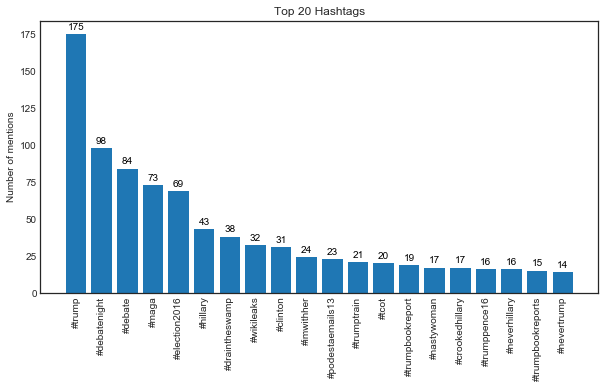

In [15]:
# plot hashtag counts
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

x = ['#'+str(i[0]) for i in hashtag_counts]
y = sorted([i[1] for i in hashtag_counts], reverse=True)

plt.bar(range(20), y)
plt.xticks(range(20), x, rotation='vertical')
plt.ylabel('Number of mentions')

for i, v in enumerate(y):
    plt.text(i, v+3, v, color='black', ha='center')

plt.title('Top 20 Hashtags')

plt.show()

The #trump hashtag was mentioned 4x more than #hillary. The second and third most popular hashtags are related to the presidential debate that occurred on Oct. 19, 2016.

Since our data set covers only 4 minutes and 40 seconds, we couldn't capture any relevant trending website link.

In [16]:
l = []
tweets.urls.apply(lambda x: [l.append(i.lower()) for i in x])
Counter(l).most_common(50)

url_counts = Counter(l).most_common(20)

for i in url_counts:
    print(i[0], '- {} shares '.format(i[1]))

https://twitter.com/double_cupp_me/status/789088080426831872 - 10 shares 
https://twitter.com/cnn/status/789249378280144896 - 9 shares 
https://twitter.com/donaldjtrumpjr/status/789248030037774336 - 7 shares 
https://twitter.com/tusk81/status/789134196614631425 - 6 shares 
https://twitter.com/politico/status/789226507579326464 - 6 shares 
https://twitter.com/braddjaffy/status/789241511326183424 - 5 shares 
https://twitter.com/danmannarino/status/789248901337538562 - 5 shares 
https://twitter.com/keitholbermann/status/789243226624520194 - 5 shares 
http://bit.ly/2eyenr8 - 5 shares 
https://twitter.com/rpyers/status/789235556253249536 - 4 shares 
http://cbsnews.com/live - 4 shares 
http://www.foxnews.com/politics/2016/10/20/clintons-debate-reference-to-nuclear-response-time-raises-eyebrows.html - 4 shares 
https://twitter.com/blicqer/status/789249666923626497 - 4 shares 
http://www.breitbart.com/video/2016/10/20/cnns-starr-clintons-answer-on-nuke-launch-time-used-extremely-classified-inf

# TF-IDF and parts of speech model

Now that our Tweets are cleaned, let's do some natural language processing. Each Tweet will be treated as a sentence. We'll start by creating a "*Term-Frequency - Inverse Document Frequency model*" (TF-IDF).

The first step is to convert words to SpaCy tokens to create a bag-of-words model. Only nouns and adjectives are counted. Words that don't carry much information (called "*[Stop words](https://gist.github.com/sebleier/554280)*"), are filtered. Also, words are converted to their "*lemmas*" (or stem words) and then concatenated with their "*parts of speech*" (whether they're nouns, adjectives, etc...). Finally, only words that occur at least 20 times in our data set are taken into consideration.

The "*TF-IDF Matrix*" is then created. Unique weights are calculated for each sentence combining the *Term Frequency* and the *Inverse Document Frequency*:

$$tfidf_{t,d}=(tf_{t,d})(idf_t)$$

Where:

$$ tf_{t,d} = ft,d$$

    (number of times a term appears in a document) / (total number of terms in the document)


$$idf_t=log \dfrac N{df_t}$$
    
    log_e(Total number of documents / Number of documents with term t in it)


The TF-IDF score will be highest for a term that occurs a lot within a small number of sentences, and lowest for a word that occurs in most or all sentences.

In [17]:
# instantiate the SpaCy module
nlp = spacy.load('en')

# custom tokenizing function
def my_tokenizer(doc):
    tokens = nlp(doc)
    return([(token.lemma_ + token.pos_) for token in tokens
            if not token.is_stop
            and not len(token.text) == 1
            and (token.pos_=='NOUN' or token.pos_=='ADJ' or token.pos_=='ADV')])

custom_vec = TfidfVectorizer(tokenizer=my_tokenizer,
                             max_df=.5, # drop words that occur in more than XX% of the paragraphs
                             min_df=20, # only use words that appear at least X times
                             ngram_range=(1,2), # use terms with one and two words
                             use_idf=True,# we definitely want to use inverse document frequencies in our weighting
                             norm=False, # 'l2' applies a correction factor to treat longer and shorter paragraphs equally
                             smooth_idf=True) #Prevents divide-by-zero errors

In [18]:
start_time = time.time()

tfidf_matrix = custom_vec.fit_transform(tweets.cleaned_text)

print("--- %s seconds ---" % (time.time() - start_time))

--- 77.28552794456482 seconds ---


In [19]:
# instantiate series to store tokens, tweets, and hashtags information
tokens = custom_vec.get_feature_names()
clean_tweets = tweets.cleaned_text
hashtags = tweets.hashtags

Rows in our matrix represent a tweet's vector. The vectors consist of the TF-IDF scores for each Spacy token in the Tweet. The value zero is assigned to tokens that aren't featured in a sentence.

# Finding topics and representative sentences

We'll use our TF-IDF vectors to calculate Sentence Similarity and identify representative tweets as those which are highly similar to other tweets. The tweets with the highest median similarity score will be sorted to identify the most important sentences in the data set.

Sklearn's *cosine_similarity* method computes similarity as *the normalized dot product of X and Y:*

$$K(X,Y) =  <X,Y> / (||X||*||Y||)$$

<img src='cosine_sim.png' width="450">

The cosine similarity of two vectors is a number between 0 and 1.0 where a value of 1.0 means the two vectors are exactly the same. The output is a similarity matrix where each row has the cosine values of that row's tweet, and all other tweets.

**Let's generate the similarity matrix and select a random sentence to find the other tweets that are most similar to it.** We'll wrap our similarity matrix in a DataFrame where both the row and column indexes are our tweets. We'll then simply filter the specific sentence's column and sort it in descending order.

In [20]:
# generate a sentence similarity matrix
df_similarity = pd.DataFrame(cosine_similarity(tfidf_matrix), index=clean_tweets,
                            columns=clean_tweets)

sentence = 'donald i will totally accept election results if i win'
df_similarity[[sentence]].sort_values(by=[sentence],ascending=False)[:20]

cleaned_text,donald i will totally accept election results if i win
cleaned_text,
donald i will totally accept the election results if i win lol,1.000000
donald i will totally accept election results if i win cnn,1.000000
donald i will totally accept election results if i win var ooyoulaplayers ooyou,1.000000
donald i will totally accept election results if i win,1.000000
donald i pledge to totally accept election results if i win via,0.971576
donald says he will totally accept election results if he wins,0.971576
donald will totally accept election results if i win reports,0.853649
omg donald just said he will totally accept results if he wins this is unbelievable,0.810032
cnn news donald i will totally accept election results if i win,0.779040


The first four sentences have a score of 1 meaning that they're perfectly identical. That's because terms such as "var", "ooyou", "lol", and "cnn" are ignored by our tfidf vectorizer.

Notice that sentences with scores above 0.5 have at least three shared words, and above 0.6 have at least six shared words. Since we're using vectors (and not simply word counts), the order of words in sentences are also taken into consideration by the model.

To find the top most representative sentences from the data set, we'll create a feature with the *mean cosine similarity score of all sentences* and rank sentences by that feature. Let's have a look at the top 20 sentences with the highest mean cosine similarity score.

In [21]:
df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

df_similarity[['mean_similarity']].sort_values('mean_similarity',ascending=False).head(20)

cleaned_text,mean_similarity
cleaned_text,
donald warns that other communities are poised to steal the election,0.107764
donald will not promise he has going to accept fraudulent stolen election,0.107764
in donald we trust,0.097612
why donald could still pull off a surprise,0.097612
box office preview can jack reacher donald,0.097612
donald is taking advantage of a certain group of his followers who lack the knowledge for critical thinking and ana,0.097612
yesterday was the least orange i ve ever seen donald,0.097612
the closest donald will ever get to an emmy is when alec baldwin wins one for playing him,0.097612
rename it lol no it will always be remembered as the failed obamacare donald,0.097612


The tweets with highest average cosine similarity score don't seem too relevant. The top *mean similarity score* among all tweets is just 0.1. That's because our data set has many tweets about many topics. Let's see if we can sort tweets by topics by creating clusters.


# Unsupervised Clustering

We'll use unsupervised clustering methods to sort our tweets by topics and then recalculate the *mean cosine similarity scores* of sentences within clusters.

#### Visualizing the geometry of our data in lower dimensions

To begin with, we'll use [Principal Component Analysis (PCA)](http://scikit-learn.org/stable/modules/decomposition.html#pca) to generate three features (also called *dimensions*) for plotting purposes. We'll plot the data in three dimensions to look at its geometry and gain insights over which clustering method to use, according to [this comparison of the clustering algorithms, also from Sklearn](http://scikit-learn.org/stable/modules/clustering.html).

Also, we'll generate Kmeans clusters of varied sizes for our first clustering attempt. Kmeans is one of the most popular clustering methods, being relatively fast and scalable.

#### K-Means Clustering

K-means is a method to cluster data points with similar variances. The algorithm tries to choose means (called centroids) that minimize inertia. The formula for inertia is:

$$\sum(\bar{x}_c - x_i)^2$$

Inertia is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

#### Evaluating Clusters

We'll use the *silhouette coefficient* method to evaluate our clusters. For each datapoint, the coefficient is the difference between the mean distance between that datapoint and all other points in its cluster ($a_i$) and the mean distance between that datapoint and all other points in the *nearest other* cluster ($b_i$), divided by whichever of the two values is highest:  

$$\dfrac{b_i-a_i}{max(b_i,a_i)}$$

The mean of the silhouette coefficients for all datapoints is the silhouette coefficient for that clustering solution on that data.  Values range from -1 for very bad clusters to +1 for very dense clusters.

We also want to look at how our tweets are distributed among clusters. We don't want to concentrate too many of our tweets in a single cluster. We also don't want clusters with too few tweets.

In [22]:
pca = PCA(n_components=3)

data3D = pca.fit_transform(tfidf_matrix.todense())

# Store results of PCA in a data frame
result=pd.DataFrame(data3D, columns=['PCA%i' % i for i in range(3)])


Silhouette avg 5 clusters: 0.6789045485272469


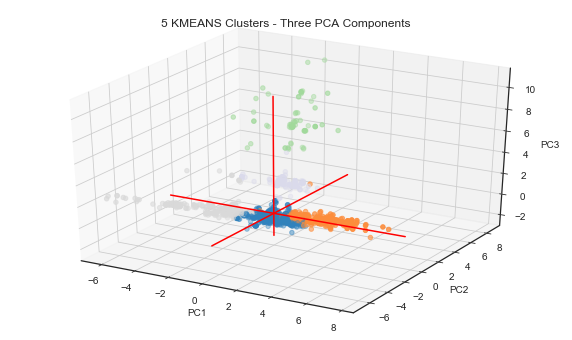

Number of observations per cluster:
0    3716
1    740 
4    548 
3    200 
2    78  
dtype: int64

-------------

Silhouette avg 10 clusters: 0.6761246820862606


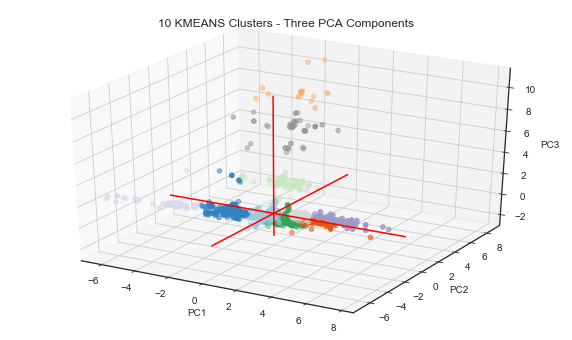

Number of observations per cluster:
1    2661
4    1004
9    521 
0    486 
5    198 
6    141 
2    98  
7    94  
8    62  
3    17  
dtype: int64

-------------

Silhouette avg 15 clusters: 0.6777420866427722


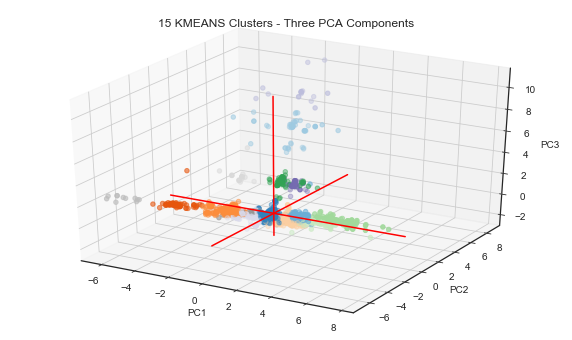

Number of observations per cluster:
0     2589
5     1003
1     507 
4     410 
7     141 
11    130 
6     123 
8     98  
3     84  
9     68  
2     61  
12    23  
14    17  
10    17  
13    11  
dtype: int64

-------------

Silhouette avg 20 clusters: 0.6044524540819018


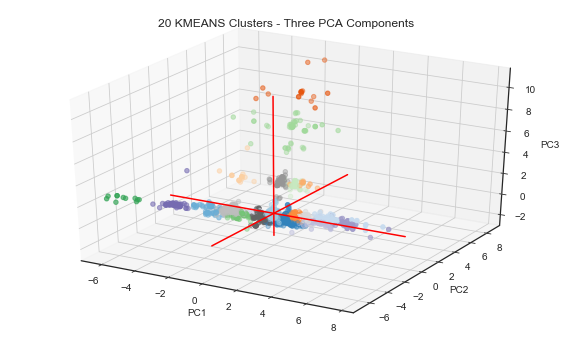

Number of observations per cluster:
2     2429
0     1002
5     411 
18    351 
16    216 
17    114 
19    101 
3     98  
14    90  
9     77  
12    75  
11    68  
1     67  
10    61  
13    46  
15    21  
7     17  
4     17  
8     11  
6     10  
dtype: int64

-------------


In [23]:
n_clusters = [5, 10, 15, 20]

for i in n_clusters:
    kmeans_array = KMeans(
        n_clusters=i, algorithm='full', n_init=100).fit_predict(data3D)

    silhouette_avg = silhouette_score(data3D, kmeans_array)

    print('\nSilhouette avg {} clusters:'.format(i), silhouette_avg)

    # Plot initialisation
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=kmeans_array, cmap="tab20c", s=20)

    # draw axis lines through space:
    xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("{} KMEANS Clusters - Three PCA Components".format(i))
    plt.show()

    print('Number of observations per cluster:')
    print(pd.value_counts(kmeans_array))
    print('\n-------------')

We can see that our data does not have a flat geometry (some observations were plotted with z-axis values higher than zero). Cluster sizes are uneven. There seems to be many clusters and they are mostly connected to each other.

Also, the shape of the data is definitely not [isotropic](https://en.wikipedia.org/wiki/Isotropy). The geometry does not have similar values when measured in different directions, but is rather stretched along the x-axis. This indicates that Kmeans is not the ideal clustering method for this data set.

Let's try using Agglomerative Clustering. According to Sklearn, the usecase for this method is when you have "*many clusters, possibly connectivity constraints, non Euclidean distances*".

Also, Agglomerative Clustering is a hierarchical clustering method, which may be useful for NLP data where there can be subtopics within topics. This may be the case with the observations that are plotted with z=0, and that are spread along the x=axis.

Still according to Sklearn, *the [AgglomerativeClustering](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy: Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.*


Silhouette avg 5 clusters: 0.67842107038359


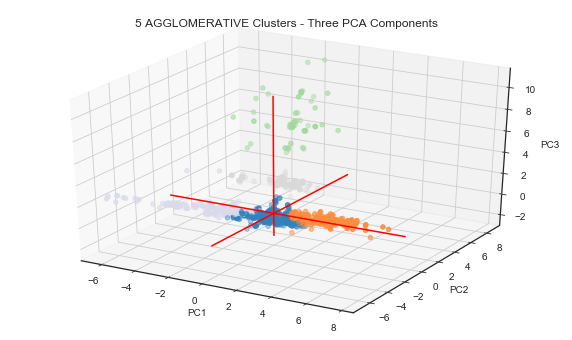

Number of observations per cluster:
0    3719
1    752 
3    527 
4    205 
2    79  
dtype: int64

-------------

Silhouette avg 10 clusters: 0.6352512234402892


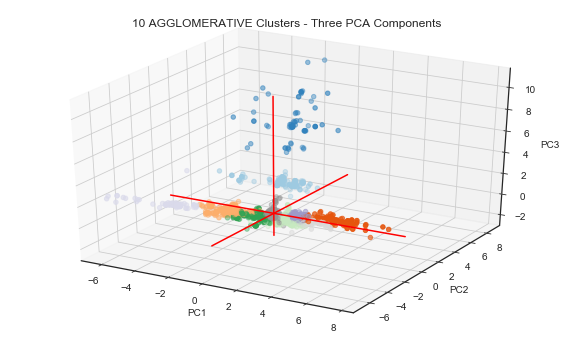

Number of observations per cluster:
8    2463
5    982 
6    484 
3    434 
4    274 
1    205 
2    170 
9    98  
7    93  
0    79  
dtype: int64

-------------

Silhouette avg 15 clusters: 0.6379233879300873


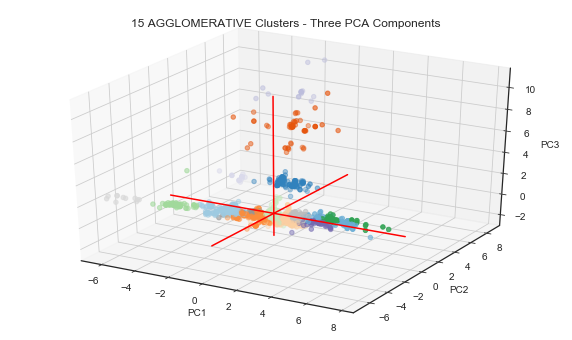

Number of observations per cluster:
8     2463
5     982 
13    484 
2     413 
4     274 
0     190 
9     98  
1     95  
7     82  
6     75  
3     64  
12    21  
11    15  
10    15  
14    11  
dtype: int64

-------------

Silhouette avg 20 clusters: 0.6085947704817865


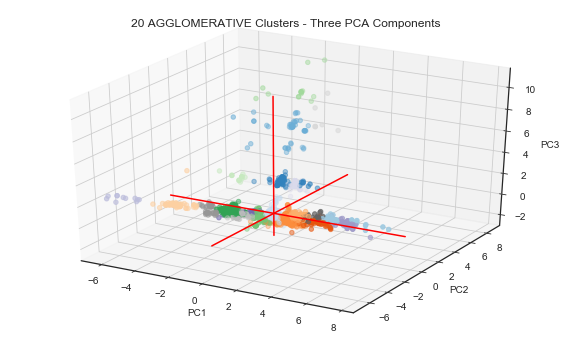

Number of observations per cluster:
3     2463
5     982 
6     484 
8     359 
9     200 
0     123 
4     98  
7     82  
2     75  
18    74  
15    67  
1     57  
17    54  
16    50  
13    45  
12    21  
10    15  
11    15  
14    11  
19    7   
dtype: int64

-------------


In [24]:
from sklearn.cluster import AgglomerativeClustering

for i in n_clusters:
    
    ac_array = AgglomerativeClustering(
        n_clusters=i, linkage='ward').fit_predict(data3D)

    silhouette_avg = silhouette_score(data3D, ac_array)

    print('\nSilhouette avg {} clusters:'.format(i), silhouette_avg)

    # Plot initialisation
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=ac_array, cmap="tab20c", s=20)

    # draw axis lines through space:
    xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("{} AGGLOMERATIVE Clusters - Three PCA Components".format(i))
    plt.show()

    print('Number of observations per cluster:')
    print(pd.value_counts(ac_array))
    print('\n-------------')

Kmeans and Agglomerative Clustering produce similar results, both in terms of their silhouette scores and cluster sizes. Kmeans seems to have better grouped the data plotted on the z-dimension (or third component). This may be an indication that the method will be better fit for higher dimensional data.

#### Dimension reduction
Our data has many dimensions so it's worthwhile doing some dimension reduction before generating our final clusters.  We'll use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity). SVD works well with sparse matrices and is frequently used on TF-IDF matrices.

In [25]:
print('TF-IDF matrix shape', tfidf_matrix.shape)

start_time = time.time()

# use SVD to reduce the feature space and normalize the matrix
svd = TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# inspect the variance explained by our reduced features
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("--- %s seconds ---" % (time.time() - start_time))

print("Percent variance captured by all components:", total_variance*100)
print('LSA matrix shape', lsa_matrix.shape)

TF-IDF matrix shape (5282, 223)
--- 0.5431859493255615 seconds ---
Percent variance captured by all components: 86.03076331541968
LSA matrix shape (5282, 150)


Let's iteratively generate Kmeans clusters with varied sizes and measure their silhouette scores. We'll choose the number of clusters that not only produces higher scores, but also clusters with similar sizes.

In [26]:
n_clusters = [5,6,10,15,20]

for i in n_clusters:

    start_time = time.time()

    kmeans_array = KMeans(
        n_clusters=i, algorithm='full', n_init=50).fit_predict(lsa_matrix)

    print("\n--- {} seconds ---".format(time.time() - start_time))

    silhouette_avg = silhouette_score(lsa_matrix, kmeans_array)
    
    print('Silhouette avg {} clusters:'.format(i), silhouette_avg)
    
    print(pd.value_counts(kmeans_array))


--- 4.4917991161346436 seconds ---
Silhouette avg 5 clusters: 0.09280191393613092
1    3062
4    728 
0    675 
2    559 
3    258 
dtype: int64

--- 5.094642877578735 seconds ---
Silhouette avg 6 clusters: 0.09882056524463659
5    2942
3    659 
1    625 
0    520 
4    281 
2    255 
dtype: int64

--- 4.721803903579712 seconds ---
Silhouette avg 10 clusters: 0.11371390983452054
9    2591
6    498 
1    485 
0    464 
8    348 
5    281 
3    236 
7    159 
4    143 
2    77  
dtype: int64

--- 5.479990005493164 seconds ---
Silhouette avg 15 clusters: 0.1270882800188892
8     2727
0     453 
4     441 
3     263 
5     228 
2     218 
12    216 
11    150 
6     136 
10    135 
7     87  
14    77  
13    62  
1     61  
9     28  
dtype: int64

--- 6.353731870651245 seconds ---
Silhouette avg 20 clusters: 0.14475397186813832
4     2482
6     489 
3     345 
15    229 
5     227 
10    203 
18    147 
17    142 
16    130 
14    103 
2     102 
19    101 
7     91  
8     85  
9     

Although smaller clusters will generally have higher silhouette scores, we may not want to have clusters with too few samples, as it may be difficult to extract information from them. In this context, the best silhouette score / cluster sizes option seems to be 15 Kmeans clusters.

In [28]:
n_clusters = 15

start_time = time.time()

kmeans_array = KMeans(n_clusters=n_clusters, algorithm='full', n_init=50).fit_predict(lsa_matrix)

silhouette_avg = silhouette_score(lsa_matrix, kmeans_array)

print('Silhouette avg = {}'.format(silhouette_avg))

print("\n--- {} seconds ---".format(time.time() - start_time))

print(pd.value_counts(kmeans_array))

Silhouette avg = 0.13154920104004228

--- 7.3869428634643555 seconds ---
4     2218
1     531 
9     439 
3     346 
11    255 
7     226 
5     212 
6     168 
14    148 
12    148 
13    137 
10    135 
2     124 
0     102 
8     93  
dtype: int64


### Inspecting the distribution of hashtags in clusters

Let's count the occurence of the top 20 hashtags within our clusters and see if they've been sorted in any way.

In [29]:
# store the LSA matrix in a pandas dataframe
df = pd.DataFrame(lsa_matrix, index=clean_tweets)

# insert a column to store kmeans clusters
df.insert(0,'kmeans', 0)

df['kmeans'] = kmeans_array

# generate a list with the top hashtags
top_hashtags = [i[0] for i in hashtag_counts]

# insert zero-valued columns with the names of the top hashtags
for i in top_hashtags:
    df.insert(1,i,0)

df.insert(0, 'hashtags', hashtags.values)

df.head(1)

,hashtags,kmeans,nevertrump,trumpbookreports,neverhillary,trumppence16,crookedhillary,nastywoman,trumpbookreport,tcot,trumptrain,podestaemails13,imwithher,clinton,wikileaks,draintheswamp,hillary,election2016,maga,debate,debatenight,trump,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
cleaned_text,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sharing selfies of completed ballots on social media a misdemeanor in colorado,[election2016],4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.078604,-0.003669,-0.008583,-0.028982,-0.00188,0.049533,0.055907,-0.010023,-0.037997,-0.09184,-0.09695,0.049092,0.028605,-0.119374,-0.054628,0.309813,0.434731,0.457096,-0.089394,-0.143951,-0.207719,-0.087128,-0.22076,0.05297,0.08742,0.140897,-0.139645,-0.039304,...,0.038287,-0.006597,-0.034874,0.13444,0.018083,-0.037331,0.059577,0.031608,0.079582,0.047588,-0.079239,-0.051494,0.010568,-0.020998,-0.049804,0.059311,-0.015858,-0.033259,-0.07423,0.082592,-0.027476,0.005855,0.028457,-0.005193,-0.041734,0.046617,0.006705,0.030963,-0.066504,0.020634,0.024591,-0.027194,0.071611,0.010837,-0.078057,-0.008219,0.024238,0.007482,0.009639,0.052945,0.037379,-0.048352,-0.021949,0.005957,0.022499,-0.050079,-0.027893,0.076594,0.004074,0.111385


In [30]:
# reset the dataframe index
df.reset_index(inplace=True)

# count the occurrence of each of the top hashtags
for i, hashlist in enumerate(df.hashtags):
    for hashtag in hashlist:
        if hashtag in top_hashtags:
            df.loc[i,hashtag]+=1

tweets['kmeans_clusters'] = df.kmeans.values
            
df[['hashtags','maga','trumppence16','debatenight']][df.maga!=0].head(6)

,hashtags,maga,trumppence16,debatenight
34,[maga],1,0,0
67,"[debatenight, maga]",1,0,1
69,[maga],1,0,0
220,"[economy, trumppence2016, maga]",1,0,0
245,[maga],1,0,0
297,"[trumppence16, maga]",1,1,0


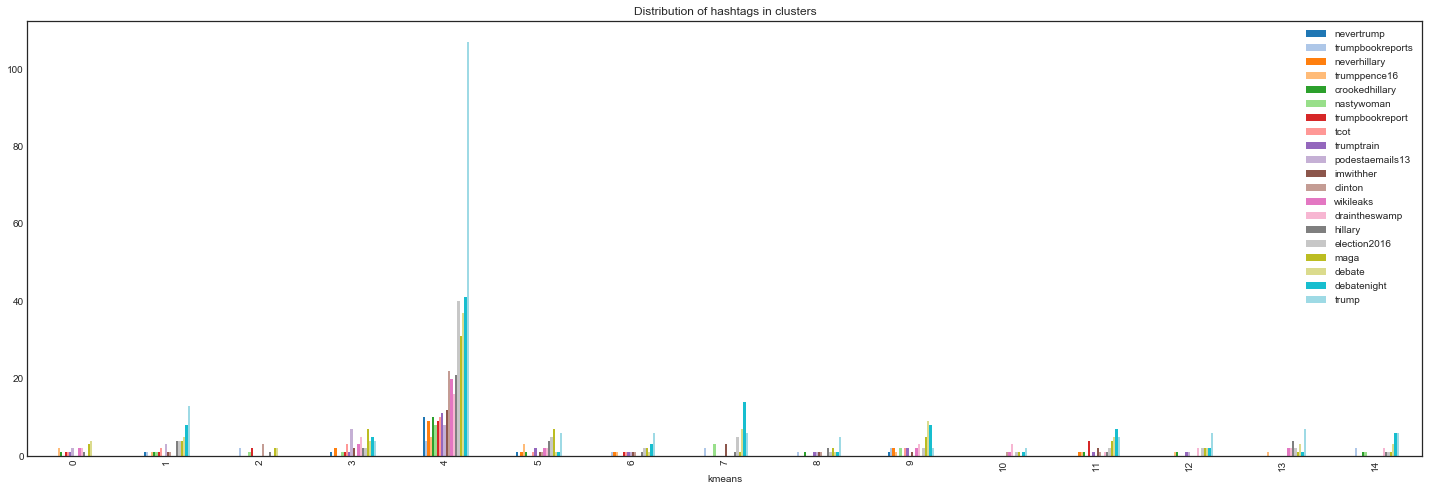

In [31]:
df.iloc[:,2:23].groupby('kmeans').sum().plot.bar(figsize=(25,8),colormap='tab20')
plt.title('Distribution of hashtags in clusters')
plt.show()

### Cosine similarity scores of clusters

It looks like our hashtags are distributed among all clusters, which doesn't help us say whether our clusters have successfully sorted topics together. Let's calculate the **average cosine similarity of each cluster** to see if they're grouping similar tweets together.

We'll also **rank sentences within clusters by their _mean cosine similarity scores_** and see if this helps us find representative topics.

In [32]:
def get_similarities(num_sents):
    
    sim_sents = collections.OrderedDict()
    
    mean_sims = {}
    
    for i in range(n_clusters):
        
        df_similarity = pd.DataFrame(cosine_similarity(tfidf_matrix[kmeans_array==i,:]),
                                   index=clean_tweets[kmeans_array==i],
                                   columns=clean_tweets[kmeans_array==i])
        
        df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))
        
        mean_similarity = df_similarity.mean_similarity.mean()
        
        mean_sims['cluster {}'.format(i)] = mean_similarity

        top_sents = df_similarity.sort_values('mean_similarity',ascending=False)[:num_sents].index
        
        sim_sents['cluster_{} | {} tweets | mean similarity: {}'.format(
            i, df_similarity.shape[0], mean_similarity)] = top_sents

    return sim_sents, mean_sims

Let's print out the tweets in one of the clusters, along with the number of tweets and the cluster's mean similarity score.

In [36]:
sim_10, cluster_sims = get_similarities(10)

print('cluster_0 | 102 tweets | mean similarity: 0.49397516477344017')

for i, tweet in enumerate(sim_10['cluster_0 | 102 tweets | mean similarity: 0.49397516477344017']):
    print('\n{})'.format(i),tweet)

cluster_0 | 102 tweets | mean similarity: 0.49397516477344017

0) heart wrenching tweetstorm describes clinton foundations lifesaving work via

1) wikileaks bombshell hillary removed algeria from terror list after they donated to clinton foundation

2) if you want to make millions just start a clinton like foundation

3) methinks john q public figuring out clinton foundation is a nest of snakes

4) wikileaks pelosi distancing herself from clinton foundation pelosi clintons will have to answer for

5) donald hillary should give back clinton foundation money to islamic governments

6) haitian president exposes the clinton foundation hillary clinton tried to bribe me

7) nobody investigates the irs the clinton foundation planned parenthood no doj no media notta

8) haitians protest outside hillary clintons office over billions stolen by clinton foundation

9) wikileaks emails reveal clinton foundation conflicts of interest via


In [37]:
print('Maximum cluster similarity:', max(cluster_sims.values()))
print('Minimum cluster similarity:', min(cluster_sims.values()))
print('Mean cluster similarity:', np.mean(list(cluster_sims.values())))

cluster_sims

Maximum cluster similarity: 0.49397516477344017
Minimum cluster similarity: 0.0075944138953249266
Mean cluster similarity: 0.3138130785159589


{'cluster 0': 0.49397516477344017,
 'cluster 1': 0.2546483143830363,
 'cluster 10': 0.38221070966817633,
 'cluster 11': 0.317341727181788,
 'cluster 12': 0.40279118330673136,
 'cluster 13': 0.3482512220549049,
 'cluster 14': 0.21291600725762755,
 'cluster 2': 0.3942476156400455,
 'cluster 3': 0.25054038662590217,
 'cluster 4': 0.0075944138953249266,
 'cluster 5': 0.23577215937399248,
 'cluster 6': 0.21447501085103687,
 'cluster 7': 0.3604475055633494,
 'cluster 8': 0.4169564139480441,
 'cluster 9': 0.41502834321598453}

Cluster 0 does seem to group tweets about the Clinton Foundation. The maximimum cluster similarity is 0.49. Averge cluster similarity is 0.31.

### Topic extraction

If we break down the clusters further, we may find *Latent Variables*, which can be thought of as hidden topics within the data. For example, the word *election* may be featured in different hidden topics (e.g., *election day* vs. *election result*). We’ll use **Non-Negative Matrix Factorization** (NNMF) to extract our latent variables.

NNMF is a dimension reduction method similar to PCA that searches for two matrices that, when multiplied together, result in the original TF-IDF matrix. The method applies a constraint that all three matrices must contain no negative values, leading to approximate values:

$$tfidf \approx WH$$

In text modeling, $W$ represents the topics, and $H$ describes whether, and to what extent, each topic applies to each document.

Sklearn's NNMF method applies the coordinate descent algorithm to find values for $W$ and $H$ that result in a matrix as close to the original TF-IDF matrix as possible. As with LSA, the goal is to reproduce the TF-IDF matrix using a smaller set of components, which we then call 'topics.' Components with the highest loading indicate a greater probability of featuring a given topic.

We'll use NMF to extract topics from clusters. To do so, we'll apply NMF to each cluster in our TF-IDF matrix and **generate a _components matrix_ where the rows are the TF-IDF vectors of all tweets within a cluster, and the columns are the NMF components**. The number of resulting components will be proportional to the number of tweets within clusters.

Then, for each *components matrix*, we'll iterate over its columns and **extract the top ten tweets that have the highest component loadings**.

In [38]:
def extract_topics(method, tfidf_mtx, num_sents):
    
    sim_sents = collections.OrderedDict()

    for i in range(n_clusters):
        
        temp_index = clean_tweets[kmeans_array==i]
        
        len_cluster = len(temp_index)
        
        temp_matrix = tfidf_mtx[kmeans_array==i,:]
        
        n_components = int(np.ceil(temp_matrix.shape[0] * .01))
        if n_components > 10:
            n_components = 10
        
        print('Cluster {}: {} observations'.format(i, len_cluster))
        
        # instantiate SVD, LDA and NMF to reduce the feature space and normalize the matrix
        svd = TruncatedSVD(n_components)
        lsa = make_pipeline(svd, Normalizer(copy=False))

        lda = LDA(n_components=n_components,
                  doc_topic_prior=None, # prior = 1/n_documents
                  topic_word_prior=1/20,
                  learning_decay=0.7, # convergence rate
                  learning_offset=10.0, # causes earlier iterations to have less influence on the learning
                  max_iter=20, # when to stop even if the model is not converging (to prevent running forever)
                  evaluate_every=-1, # do not evaluate perplexity, as it slows training time
                  mean_change_tol=0.001, # stop updating the document topic distribution in the E-step when mean change is < tol
                  max_doc_update_iter=100, # when to stop updating the document topic distribution in the E-step even if tol is not reached
                  n_jobs=1, # set to -1 to use all available CPUs to speed up processing time
                  verbose=0, # amount of output to give while iterating
                  random_state=0
                 )

        nmf = NMF(alpha=0.0, 
                  init='nndsvdar', # how starting value are calculated
                  l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
                  max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
                  n_components=n_components, 
                  random_state=0, 
                  solver='cd', # Use Coordinate Descent to solve
                  tol=0.0001, # model will stop if tfidf-WH <= tol
                  verbose=0 # amount of output to give while iterating
                 )

        # generate the components matrix
        if method == 'lsa':
            components = lsa.fit_transform(temp_matrix)
            print('Explained variance ratio:', sum(svd.explained_variance_ratio_))

        elif method == 'lda':
            components = lda.fit_transform(temp_matrix)

        else:
            components = nmf.fit_transform(temp_matrix)

        # store components to file
        np.save('{}_cl_{}.npy'.format(method, i), components)
        
        df_components = pd.DataFrame(components, index=clean_tweets[kmeans_array==i])
        
        for col in df_components.columns:
            top_sents = df_components[col].sort_values(ascending=False)[:num_sents].index
            sim_sents['cluster_{}, component {}'.format(i, col)] = top_sents
        
    return sim_sents

In [39]:
nmf_topics = extract_topics('nmf', tfidf_matrix, 10)

for key, value in nmf_topics.items():
    if (key == 'cluster_12, component 0') or (key == 'cluster_12, component 1'):
        print('\n--------------\n',key)
        for j, sent in enumerate(value):
            print('\n{})'.format(j),sent)

Cluster 0: 102 observations
Cluster 1: 531 observations
Cluster 2: 124 observations
Cluster 3: 346 observations
Cluster 4: 2218 observations
Cluster 5: 212 observations
Cluster 6: 168 observations
Cluster 7: 226 observations
Cluster 8: 93 observations
Cluster 9: 439 observations
Cluster 10: 135 observations
Cluster 11: 255 observations
Cluster 12: 148 observations
Cluster 13: 137 observations
Cluster 14: 148 observations

--------------
 cluster_12, component 0

0) only racist people say they are the least racist people you have ever met believe me donald is racist

1) donald is a great american people wonder why more good people do not run look at the ringer democrats put a citizen through

2) giuliani just predicted dems will steal the election in pa by busing in people from out of state to pose as dead people

3) this election and everything going on in the world has made me unfriend so many people on facebook mostly people from highschool

4) these are the cartel in washington thes

These sentences seem indeed similar to each other. We can't apply cosine similarity to our component matrices, since each matrix will have the same tweets as our clusters.

Let's instead **extract top keywords from each component** and see if those keywords summarize the main topics within each component.

To do so, we'll take our component matrices and multiply them by the transpose of our TF-IDF matrix. The result will be a new matrix for each cluster, where the row index is our tokens (originally in the TF-IDF matrix columns) and the columns are our NMF components.

We'll then extract the top words (to be more precise the top tokens) with the highest component loadings.

In [40]:
def get_top_words(method, n_top_words):
    
    topwords_dict = collections.OrderedDict()
    
    for i in range(n_clusters):
        
        tfidf_mtx = tfidf_matrix[kmeans_array==i]
        
        try:
            filename = '{}_cl_{}.npy'.format(method, i)
            comp_matrix = np.load(filename)
            #print('cluster {} - {} tweets'.format(i, comp_matrix.shape[0]))
        except FileNotFoundError:
            continue        

        # load scores for each token on each component and wrap in dataframe
        df_wordloads = pd.DataFrame(tfidf_mtx.T.dot(comp_matrix), index=tokens)

        # sort top words for each component column
        for column in df_wordloads.columns:
            sortedwords = df_wordloads.iloc[:,column].sort_values(ascending=False)

            # choose the N highest loadings
            chosen = sortedwords[:n_top_words]

            temp_dict = collections.OrderedDict()

            # combine loading and index into an ordered dict
            temp_dict['{}_{}'.format(i, column)] = collections.OrderedDict(
                zip(chosen.index, round(chosen,2)))

            topwords_dict.update(temp_dict)
    
    # save dict to file
    np.save('topwords_{}.npy'.format(method), topwords_dict)

    return topwords_dict

In [80]:
nmf_top_words = get_top_words('nmf', 10)

print('\nList of topics - COMPONENT CLASS 12_0:')

nmf_top_words['12_0']


List of topics - COMPONENT CLASS 12_0:


OrderedDict([('peopleNOUN', 408.48),
             ('donaldNOUN', 53.14),
             ('americanADJ', 39.2),
             ('racistADJ', 34.81),
             ('goodADJ', 27.02),
             ('mediumNOUN', 26.77),
             ('electionNOUN', 26.71),
             ('worldNOUN', 16.92),
             ('clintonNOUN', 16.55),
             ('demNOUN', 14.61)])

**Indeed the list of topics extracted from component class 12_0 are similar to the list of top 10 sentences from that same component class.** These lists of topics can serve as useful references for researchers who want to sort through the main topics in the Twitter political debate.

## Classifying sentences by cluster and component

Let's see if we can now assign a "*topic class*" to each tweet. We'll load our component matrices, and create a "*top component*" column feature using Panda's idxmax() function. The new feature will indicate, for each Tweet, the number of the component with the highest loading. **We'll then get back to our original Tweets dataframe and assign for each tweet its *topic class*, consisting of the number of its cluster combined with the number of its component with the highest loading.**

In [81]:
tweets['comp_class'] = np.nan

for i in range(n_clusters):
    
    temp_df = pd.DataFrame()
    
    try:
        filename = 'nmf_cl_{}.npy'.format(i)
        matrix = np.load(filename)
        temp_df = pd.DataFrame(data=matrix, index=clean_tweets[kmeans_array==i])

    except FileNotFoundError:
        tweets.loc[(tweets.kmeans_clusters==i), ['comp_class']] = '{}_0'.format(i)
        continue        
    
    temp_df.insert(0, 'top_comp', temp_df.idxmax(axis=1))
    
    temp_df['comp_class'] = str(i) + '_' + temp_df['top_comp'].astype(str)
    
    tweets.loc[(tweets.kmeans_clusters==i), ['comp_class']] = temp_df.comp_class.values

Let's start by looking at the average silhouette score of all component classes.

In [82]:
print('Number of component classes:', len(tweets.comp_class.unique()))
print('Average silhouette score of component classes:',
      silhouette_score(lsa_matrix, tweets.comp_class))

Number of component classes: 49
Average silhouette score of component classes: 0.08603833493292326


Recall that the silhouette average of our 15 components is 0.13. We now have 49 component classes, with a lower average silhouette score.

Let's calculate the cosine similarity scores for each component class. I'll also manually review a few component classes and make some anecdotal observations about them.

In [83]:
c_class_array = tweets.comp_class.values

mean_sims = {}

for i in c_class_array:
    
    tweets_array = tweets.cleaned_text[tweets.comp_class==i].values

    df_similarity = pd.DataFrame(cosine_similarity(tfidf_matrix[c_class_array==i]),
                               index=tweets_array,
                               columns=tweets_array)

    df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

    mean_similarity = df_similarity.mean_similarity.mean()

    mean_sims['c_class {} - {} tweets'.format(i, len(tweets_array))] = mean_similarity

In [84]:
print('Maximum cluster similarity:', max(mean_sims.values()))
print('Minimum cluster similarity:', min(mean_sims.values()))
print('Mean cluster similarity:', np.mean(list(mean_sims.values())))

sorted(mean_sims.items(), key=itemgetter(1), reverse=True)

Maximum cluster similarity: 0.9999999999999998
Minimum cluster similarity: 0.003744582044890355
Mean cluster similarity: 0.45336651661198196


[('c_class 9_4 - 5 tweets', 0.9999999999999998),
 ('c_class 7_2 - 6 tweets', 0.8258053222671077),
 ('c_class 9_1 - 13 tweets', 0.7713317892612854),
 ('c_class 3_1 - 29 tweets', 0.7259092389251504),
 ('c_class 1_5 - 24 tweets', 0.6924219753282893),
 ('c_class 7_0 - 68 tweets', 0.6891964066901994),
 ('c_class 1_3 - 28 tweets', 0.6556275298339955),
 ('c_class 11_1 - 32 tweets', 0.6490356523215),
 ('c_class 11_2 - 28 tweets', 0.6465859752620704),
 ('c_class 2_1 - 22 tweets', 0.6343048441840662),
 ('c_class 10_1 - 22 tweets', 0.6265685420579375),
 ('c_class 13_1 - 10 tweets', 0.61351456982768),
 ('c_class 3_2 - 18 tweets', 0.5979241784175516),
 ('c_class 9_3 - 11 tweets', 0.5824546088735084),
 ('c_class 3_3 - 32 tweets', 0.5618700327655728),
 ('c_class 1_4 - 29 tweets', 0.5614527280666446),
 ('c_class 1_2 - 33 tweets', 0.5506792351194975),
 ('c_class 0_1 - 13 tweets', 0.5478656280267558),
 ('c_class 5_1 - 80 tweets', 0.5420718213928447),
 ('c_class 1_1 - 80 tweets', 0.5408608014642917),
 ('

In [85]:
# print out tweets for anecdotal review
for i, sent in enumerate(tweets[tweets.comp_class=='12_1'].cleaned_text.sample(10)):
    print('\nSample sentence {}:\n'.format(i), sent)


Sample sentence 0:
 all the black and brown people have to leave donalds scary impact on how kids think

Sample sentence 1:
 the myth of voter fraud gets repeated over and over so much that people believe it is true

Sample sentence 2:
 crooked hillary clinton hates black people

Sample sentence 3:
 donald speaks for the people americans do not have to accept democrat voter fraud

Sample sentence 4:
 people have been using voter fraud as an excuse to suppress black votes for years

Sample sentence 5:
 according to donald voter fraud occurs when blacks mexicans women and poor people vote

Sample sentence 6:
 black people have everything to lose if they vote for donald

Sample sentence 7:
 fraud concerns are code for black people stealing election i swear you are dumb as the day is long

Sample sentence 8:
 cnn hires imps to imitate black people knowing real black people wont vote for clinton

Sample sentence 9:
 all the black and brown people have to leave donalds scary impact on how k

As expected, smaller component clusters will tend to have higher cosine similarity scores and consist of tweets with very similar topics. Larger component classes have a mixture of undefined topics.

From our anecdotal revision of the component class samples, we notice that:

- **Component classes with scores $\approx$ 0.2**: Samples tend to have mixed topics. Only a portion of the tweets will share one or two keywords. The keywords tend to be common words (tokens with high term frequency);

- **Scores $\approx$ 0.35**: Samples will share at least one keyword indicating that there is one main topic, and a few subtopics within the samples;

- **Scores $\approx$ 0.5**: Samples will have more than one related keywords - e.g., words that occur often together. At least one of the keywords will tend to be less common words (tokens with lower document frequency);

- **Scores $\approx$ 0.65**: Samples will share key terms with high IDF values (more than one words that do not appear often and that have high co-occurence) such as "accept+result+election";

- **Scores > 0.9**: Samples will consist of mostly the same keywords and key terms, in similar order.

# Network Analysis

Finally, let's do some network analysis to find the most influential Twitter users and understand how tightly knit are each presidential candidate’s networks. 

### Graphing the network

First, we'll generate one graph for each component class. Recall that we have more than 40 component classes, so we'll save the graphs to files and only display one such graph here. We'll later generate one graph of the entire network where each component class will be displayed with a different randomly assigned color.

In [86]:
comp_classes = tweets.comp_class.unique()
colorlist = [('#'+str(randint(100000, 999999))) for i in range(len(comp_classes))]

tweets['color'] = np.nan
for i in range(len(comp_classes)):
    tweets.loc[(tweets.kmeans_clusters==i), ['color']] = colorlist[i]

In [88]:
for c_class in comp_classes:

    temp_df = tweets[tweets.comp_class==c_class]

    temp_df.reset_index(inplace=True, drop=True)
    
    G = nx.DiGraph()

    for i, username in enumerate(temp_df.username):
        for user_mentioned in temp_df.user_mentions.loc[i]:
            try:
                G.edges[username, user_mentioned]['weight']+=35
                G.edges[username, user_mentioned]['color'] = temp_df.color.loc[i]
            except KeyError:
                G.add_edge(
                    username, user_mentioned, weight=1, 
                    color=temp_df.color.loc[i])

    for i, quoted_user in enumerate(temp_df[temp_df.quoted_user.notnull()].quoted_user):
            try:
                G.edges[quoted_user, temp_df.username.loc[i]]['weight']+=35
                G.edges[quoted_user, temp_df.username.loc[i]]['color'] = temp_df.color.loc[i]
            except KeyError:
                G.add_edge(
                    quoted_user, temp_df.username.loc[i], weight=1, 
                    color=temp_df.color.loc[i])
        
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

    colors = tuple(nx.get_edge_attributes(G,'color').values())

    degrees = dict(nx.degree(G))

    fig_size = temp_df.shape[0]

    fig_size = 20 if fig_size < 20 else fig_size
    
    fig = plt.figure()
    fig.set_figheight(fig_size)
    fig.set_figwidth(fig_size) 

    fig.suptitle('Component Class {}'.format(c_class),fontsize=fig_size)
    plt.title(', '.join(nmf_top_words[c_class].keys()),fontsize=fig_size*.4)
    
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, weight='weights'), # Positions the nodes relative to each other
                     with_labels=True,
                     arrows=True,
                     node_size=[(v*600*(fig_size*.05)) for v in degrees.values()],
                     #cmap=plt.cm.hot, # The color palette to use to color the nodes
                     node_color=colors, # The number of shades of color to use
                     edgelist=edges,
                     #edge_cmap=plt.cm.hot,
                     edge_color='#C6DEFF',
                     alpha=.8,
                     width=weights, # Edge width
                     font_size=6*(fig_size*0.05)
                     )

    plt.axis('off')
    fig.savefig('{}.pdf'.format(c_class))

### Network Graph - Component Class 9_0

**Keywords:**

donaldNOUN, notADV, countryNOUN, supportNOUN, moneyNOUN, taxNOUN, greatADJ, wordNOUN, resultNOUN'

<img src="9_0.png"/>

The **link weights** between nodes are calculated by how often nodes exchange information, taking into consideration the direction that the information is flowing. Accounts with heavier link weights will have exchanged information most often. Nodes with heavier link weights have thicker lines plotted on the graph.

Notice that only a few nodes have heavier link weights. Most users only communicated once during the observation period of our data set. That's understandable, considering that the ten thousand tweet samples were generated in only three minutes and fourty seconds.

**Let's now look at how the entire network graph looks like.**

In [89]:
tweets.reset_index(drop=True, inplace=True)

G = nx.DiGraph()

for i, username in enumerate(tweets.username):
    for user_mentioned in tweets.user_mentions.loc[i]:
        try:
            G.edges[username, user_mentioned]['weight']+=.001
            G.edges[username, user_mentioned]['color'] = tweets.color.loc[i]
        except KeyError:
            G.add_edge(
                username, user_mentioned, weight=.001, 
                color=tweets.color.loc[i])

for i, quoted_user in enumerate(tweets[tweets.quoted_user.notnull()].quoted_user):
        try:
            G.edges[quoted_user, tweets.username.loc[i]]['weight']+=.001
            G.edges[quoted_user, tweets.username.loc[i]]['color'] = tweets.color.loc[i]
        except KeyError:
            G.add_edge(
                quoted_user, tweets.username.loc[i], weight=.001, 
                color=tweets.color.loc[i])

### Node degrees

The **degree of a node** is the number of links connected to that node. A node's degree is the sum of its connections with other accounts. Each node has both in-degree (the number of times someone else either mentioned the user, or re-tweeted their Tweets) and out-degree (the number of times the user mentioned someone else, or re-tweeted someone else's Tweets).

Let's have a look at the top 20 nodes with highest in- and out-degrees.

In [90]:
print("The network has {} nodes and {} edges.".format(G.number_of_nodes(),G.number_of_edges()))

The network has 5628 nodes and 5178 edges.


In [91]:
top_20_in = sorted(dict(G.in_degree()).items(), key=itemgetter(1), reverse=True)[:20]

top_20_out = sorted(dict(G.out_degree()).items(), key=itemgetter(1), reverse=True)[:20]

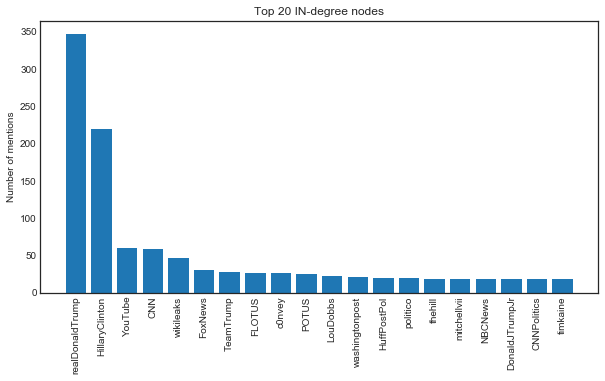

In [93]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

top_accounts = [i[0] for i in top_20_in]
in_degrees = [i[1] for i in top_20_in]
y_pos = np.arange(len(in_degrees))

plt.bar(sorted(top_accounts), in_degrees)
plt.xticks(y_pos, top_accounts, rotation='vertical')
plt.ylabel('Number of mentions')
plt.title('Top 20 IN-degree nodes')

plt.show()

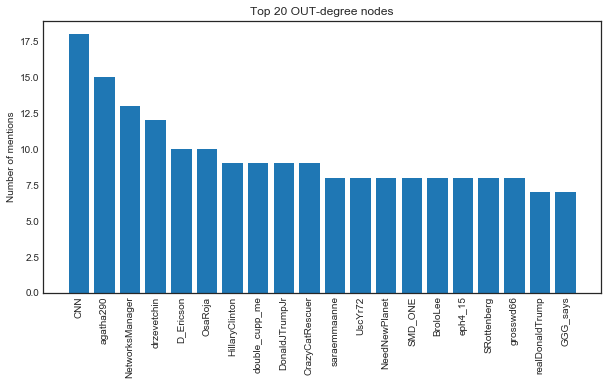

In [94]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

top_out_accounts = [i[0] for i in top_20_out]
out_degrees = [i[1] for i in top_20_out]
y_out_pos = np.arange(len(out_degrees))

plt.bar(sorted(top_out_accounts), out_degrees)
plt.xticks(y_out_pos, top_out_accounts, rotation='vertical')
plt.ylabel('Number of mentions')
plt.title('Top 20 OUT-degree nodes')

plt.show()

The realDonaldTrump account is by far the most mentioned in the network, followed by HillaryClinton. CNN was the top content producer, having mentioned or retweeted 18 other users.

### Betweeness centrality

One of the most interesting metrics in our analyis is *betweenness centrality*. It is **the measure of how many times a node is part of the path between two other nodes.** Nodes with high betweenness may be influential because of their capacity to control information passing between others. They are also the ones whose removal from the network will most disrupt communications.

*Mathematically, let $n_{s,t}^{i}$ be the number of paths from $s$ to $t$ that pass through $i$ and let $n_{s,t}$ be the total number of paths from $s$ to $t$. Recall that a path is not necessarily unique and the paths between a pair of nodes need not be node-independent, meaning they may pass through some of the same nodes. Then the betweenness centrality of node $i$ is:*

$\displaystyle{b_i = \sum_{s, t} w_{s,t}^{i} = \sum_{s, t} \frac{n_{s,t}^{i}}{n_{s,t}}}$

*where by convention the ratio $w_{s,t}^{i} = 0$ if $n_{s,t} = 0$. Notice that each pair of nodes $s, t$ contribute to the sum for $i$ with a weight $w_{s,t}^{i}$ between 0 and 1 expressing the betweenness of $i$ with respect to the pair $s, t$.*
    
source: https://www.sci.unich.it/~francesc/teaching/network/betweeness.html

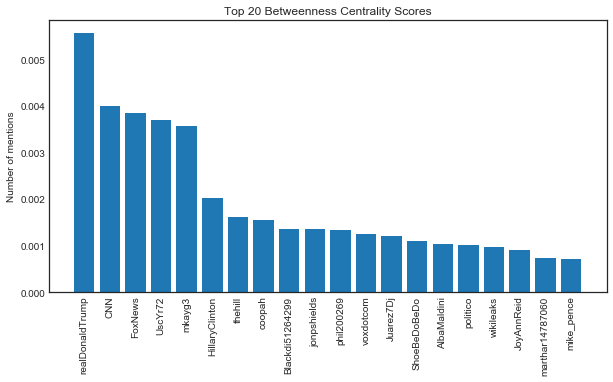

In [95]:
betweeness = sorted(nx.betweenness_centrality(G).items(), key=itemgetter(1), reverse=True)[:20]

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

top_betweeness = [i[0] for i in betweeness]
BC = [i[1] for i in betweeness]
y_pos = np.arange(len(BC))

plt.bar(y_pos, BC)
plt.xticks(y_pos, top_betweeness, rotation='vertical')

plt.ylabel('Number of mentions')
plt.title('Top 20 Betweenness Centrality Scores')
plt.show()

### Clustering coefficient

The **global clustering coefficient** is a measure of how tightly knit a network is. The local clustering coefficient of a node describes the probability that any two nodes it is linked to will also be linked to each other. The higher the clustering score, the more redundant the node.

The clustering coefficient for a node $i$ with $k$ links (degree $k_i$) can be calculated as:

$C_i= \frac{2L_i}{k_i(k_i-1)}$

Where $L_i$ is the number of links between the $k$ neighbors of node $i$. $C_i$ ranges from 0 to 1 and indicates the probability that any two neighbors of node $i$ will be linked to one another.

Another way to refer to clustering is local density. The more connected a network's nodes, the easier it is for information to flow without disruptions. The information flowing through dense networks is harder to be controlled (or censored).

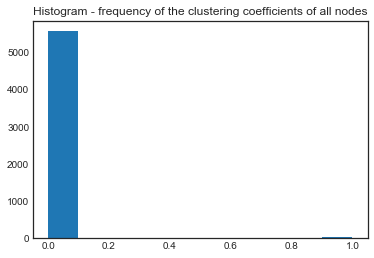

Average network clustering coefficient: 0.006387539183870326


In [96]:
# Converting to an undirected graph
UG = G.to_undirected()

# clustering measures how often nodes share links
clustering = list(nx.clustering(UG).values())
plt.hist(clustering)
plt.title('Histogram - frequency of the clustering coefficients of all nodes')
plt.show()

print('Average network clustering coefficient:', nx.average_clustering(UG))

The clustering coefficient is extremely low, indicating that most of the information was exchanged by individual pairs of nodes. Again, this is not surprising, considering that our tweets were collected in just 3 minutes and 40 seconds.

Let's look at the local clustering coefficient of the top 20 nodes with the highest degree scores, and compare them with the two presidential candidates.

In [97]:
top_20_degrees = sorted(dict(G.degree()).items(), key=itemgetter(1), reverse=True)[:20]

top_nodes = [i[0] for i in top_20_degrees]

top_nodes_avg_clustering = {}

for i in UG:
    neighbors = list(nx.all_neighbors(UG, i))
    top_nodes_avg_clustering[i] = nx.average_clustering(UG, nodes=neighbors)

names = [i[0] for i in sorted(top_nodes_avg_clustering.items(),
                              key=itemgetter(1), reverse=True)[:20]]

avg_clustering = [i[1] for i in sorted(top_nodes_avg_clustering.items(),
                                       key=itemgetter(1), reverse=True)[:20]]

names.extend(['realDonaldTrump', 'HillaryClinton'])

avg_clustering.extend(
    [top_nodes_avg_clustering['realDonaldTrump'], 
     top_nodes_avg_clustering['HillaryClinton']])

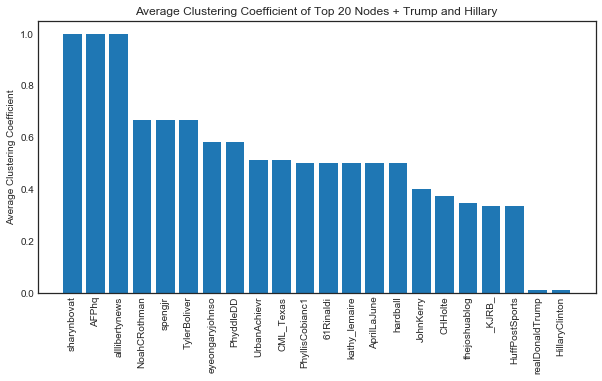

In [98]:
order = [i for i in range(len(names))]

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

plt.bar(order, avg_clustering)
plt.xticks(order, names, rotation='vertical')
plt.ylabel('Average Clustering Coefficient')
plt.title('Average Clustering Coefficient of Top 20 Nodes + Trump and Hillary')
plt.show()

The realDonaldTrump and HillaryClinton accounts have much lower local clustering coefficients than the other accounts. That's because both have very high in-degree scores (they are very frequently mentioned by other users), both accounts rarely mentioned or retweeted other users.

### Shortest path

In our final analysis, we'll visualize the entire network graph and trace the shortest path between the @realDonaldTrump and @HillaryClinton, and the @POTUS accounts.

POTUS is an acronym for "President of the United States". The account is managed by the White House.

In [99]:
tweets.reset_index(drop=True, inplace=True)

G = nx.DiGraph()

for i, username in enumerate(tweets.username):
    for user_mentioned in tweets.user_mentions.loc[i]:
        try:
            G.edges[username, user_mentioned]['weight']+=.001
            G.edges[username, user_mentioned]['color'] = tweets.color.loc[i]
        except KeyError:
            G.add_edge(
                username, user_mentioned, weight=.001, 
                color=tweets.color.loc[i])

for i, quoted_user in enumerate(tweets[tweets.quoted_user.notnull()].quoted_user):
        try:
            G.edges[quoted_user, tweets.username.loc[i]]['weight']+=.001
            G.edges[quoted_user, tweets.username.loc[i]]['color'] = tweets.color.loc[i]
        except KeyError:
            G.add_edge(
                quoted_user, tweets.username.loc[i], weight=.001, 
                color=tweets.color.loc[i])

In [100]:
shortest = nx.shortest_path(G, source='HillaryClinton', target='POTUS')
shortest

['HillaryClinton',
 'Blackdi51264299',
 'phil200269',
 'Juarez7Dj',
 'realDonaldTrump',
 'AlbaMaldini',
 'voxdotcom',
 'marthar14787060',
 'JoyAnnReid',
 'SallyAlbright',
 'POTUS']

In [101]:
shortest = nx.shortest_path(G, source='realDonaldTrump', target='POTUS')
shortest

['realDonaldTrump',
 'AlbaMaldini',
 'voxdotcom',
 'marthar14787060',
 'JoyAnnReid',
 'SallyAlbright',
 'POTUS']

In [102]:
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

colors = tuple(nx.get_edge_attributes(G,'color').values())

degrees = dict(nx.degree(G))

fig = plt.figure()
fig.set_figheight(300)
fig.set_figwidth(300) 

fig.suptitle('Shortest Path from realDonaldTrump to POTUS',fontsize=400)

pos=nx.spring_layout(G)
nx.draw_networkx(G,
                 pos, # Positions the nodes relative to each other
                 with_labels=False,
                 arrows=False,
                 node_size=[(v*1000) for v in degrees.values()],
                 cmap=plt.cm.hot, # The color palette to use to color the nodes
                 node_color=colors, # The number of shades of color to use
                 edgelist=edges,
                 #edge_cmap=plt.cm.hot,
                 edge_color='#C6DEFF',
                 alpha=.7,
                 width=.00005, # Edge width
                 )

path_edges = list(zip(shortest,shortest[1:]))

nx.draw_networkx_nodes(G,
                       pos,
                       with_labels=True,
                       node_size=[(v*1000) for v in degrees.values()],
                       nodelist=shortest,
                       node_color='#B22222',
                       font_size=1000)

nx.draw_networkx_edges(G,
                       pos,
                       with_labels=True,
                       edgelist=path_edges,
                       edge_color='#B22222',
                       width=15,
                       font_size=100)


plt.axis('off')
fig.savefig('all_tweets_path.pdf')

### Shortest path from @realDonaldTrump to @POTUS

<img src="shortest_path.png"/>

# Conclusion

### Natural Language Processing:
We have used a combination of TF-IDF modelling, unsupervised clustering, Non-negative Matrix Factorization and Cosine Similarity to extract key topics from a sample of +5,000 tweets.

Topics tend to be nested - there are usually relevant sub-topics within topics that were sorted with unsupervised clustering techniques. For example, while component class 12_0 grouped tweets about "people" in general, component class 12_1 had messages that were specifically related to "black people."

Smaller component clusters will tend to have higher cosine similarity scores and consist of tweets with highly similar topics. Larger component classes (with +500 samples) have a mixture of undefined topics.

We were able to sort 2,797 tweets (53% of all unique tweets) into component classes with cosine similarity scores of at least 0.34 - which from an anecdotal analysis share similar topics. More work would be needed to sort the larger classes that have cosine similarity scores lower than 0.34.

### Network Analysis:
Our Twitter data set is a snapshot of only 4 minutes and 40 seconds of the political debate around the 2016 US Presidential Elections in that social network.

We were able to generate network graphs and visualize the most influential Twitter users according to specific topics of interest (for topics featured in component classes with cosine similarity scores above 0.34).

Most users only communicated once during the observation period of our data set. The users @realDonaldTrump and @HillaryClinton had the highest in-degree scores and were the handles most mentioned by other users. The two most quoted or re-tweeted accounts were @CNN and @agatha290.

We found the most influential users by sorting accounts by their betweeness centrality scores (which measures how many times a node is part of the path between two other nodes). Nodes with greater betweenness centrality scores may be influential because of their capacity to control information passing between others. The top 5 most influential users were @realDonaldTrump, @CNN, @FoxNews, @UscYr72, @mkayg3, respectively.

Our network's clustering coefficient (which measures how tightly knit a network is) was very low, once again due to the short time span of our data set.

Finally, we found out that there were only five Twitter accounts separating the @realDonaldTrump user from the White House's @POTUS account; and nine accounts between @HillaryClinton and @POTUS.